In [1]:
import sys
sys.path.insert(0, '../')

from minisom import MiniSom

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

%load_ext autoreload

data = np.genfromtxt('iris.csv', delimiter=',', usecols=(0, 1, 2, 3))
data = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, data)
labels = np.genfromtxt('iris.csv', delimiter=',', usecols=(4), dtype=str)

# Initialization and training
som = MiniSom(5, 5, 4, sigma=3, learning_rate=0.5, 
              neighborhood_function='triangle', random_seed=10)

In [2]:
class_assignments = som.labels_map(data, labels)

def classify(som, data, class_assignments):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = class_assignments
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data, labels)

som.pca_weights_init(X_train)
som.train_random(X_train, 5000, verbose=False)
class_assignments = som.labels_map(X_train, y_train)

print(classification_report(y_test, classify(som, X_test, class_assignments)))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        11
  versicolor       1.00      1.00      1.00        13
   virginica       1.00      1.00      1.00        14

   micro avg       1.00      1.00      1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



In [4]:
#SOM_Molecule fingerPrint—— CDK fix smiles

In [64]:
import os 
import rdkit
from rdkit import Chem, DataStructs
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True


In [65]:
import sys, csv
#sys.path.insert(0, 'SOM_fp')
#sys.path
from minisom import MiniSom
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
#import pandas as pd

In [66]:
import pandas as pd
fiter=pd.read_csv('SOM_fp\cdk_all_eact.csv')
Neg=fiter.loc[(fiter['Activity_Flag'] == 'N')]# & (fiter['column_name'] <= B)]
Act=fiter.loc[(fiter['Activity_Flag'] == 'A')]#可能其它的SOM 用到到 总活 or 总非活

In [67]:
#直接从网上下载的 CDK smiles rdkit 可能有未识别的 修正
def RdkitSmilseFix(path='SOM_fp/cdk_all_eact.csv',path_failSmiles='SOM_fp/fails.smi',
                   delimiter=','):
    reader = csv.reader(open(path, 'r'), delimiter=delimiter)
    header = next(reader)
    cols_to_read=[col for col in range(len(header))]
    data_full = np.array(list(reader))

    for i,s in enumerate(data_full[:,10]):
        m=Chem.MolFromSmiles(s)
        if m is not None:
            ss=Chem.MolToSmiles(m)
        else:
            print(f'Rdkit failed reading{data_full[i]}')
            with open(path_failSmiles,'a+') as af:
                af.write(str(data_full[i].tolist())+'\n')


In [68]:
RdkitSmilseFix(path='SOM_fp/cdk_all_eact.csv',
               path_failSmiles='SOM_fp/fails.smi',
               delimiter=',')
#USE the SDG or openbable to fix the fail SMILES

O=C1Nc2ccccc2[C@H]1C=Nc1ccc2[nH]c(O)nc2c1


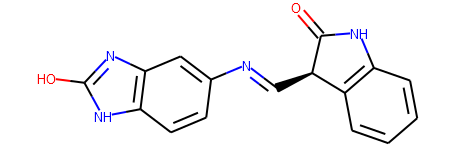

In [69]:
#Chem.MolFromSmiles('O=C1[NH2]C2=[C]C=CC=C2[C]1C=[NH]C3=CC=C4NC(O)=NC4=C3')
am=Chem.MolFromSmiles('n1c(O)[nH]c(c12)ccc(c2)N=C[C@H]3C(=O)Nc(c34)cccc4')
c_s=Chem.MolToSmiles(am)
print(c_s)
#sdg: n1c(O)[nH]c(c12)ccc(c2)\N=C\[C@H]3C(=O)Nc(c34)cccc4 去掉 \ , 用C_S替换原数据
am#fix 后继续run RdkitSmilseFix,  最后手动 修改数据cdk_all_eact--》 MergeLable_2col

In [80]:
def make_fingerprint(smiles: str,
                     fingerprint: str='morgan',
                     radius: int = 2,
                     num_bits: int = 2048,
                     use_counts: bool = False) -> np.ndarray:
    if type(smiles) == str:
        mol = Chem.MolFromSmiles(smiles)
    else:
        mol = smiles
    if fingerprint=='morgan':
        if use_counts:
            fp_vect = AllChem.GetHashedMorganFingerprint(mol, radius, nBits=num_bits)
        else:
            fp_vect = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=num_bits)
        fp = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp_vect, fp)
    else:
        raise ValueError(f'for now only support morgan fingerprint')
    return fp


def read_smiles_property_file(#args,# args will be use in the read_split_scale_write() do not remove
                              path, #cols_to_read, #in multitask use multi cols
                              delimiter=',',  # change , the inputfile
                              fingerprint=True,
                              keep_header=False):  # todo merge args path or something
    reader = csv.reader(open(path, 'r'), delimiter=delimiter)
    header = next(reader)
    #cols_to_read=[col for col in range(len(header))]
    cols_to_read=[0,1]#as the string gensymbol not use
    data_full = np.array(list(reader))#should also consider 0
    print(f'data_full.shape{data_full.shape}')
    if keep_header:
        start_position = 0
    else:
        start_position = 1
    assert len(data_full) > start_position
    data = [[] for _ in range(len(cols_to_read))]  # todo split the data by cols as lists, get this
    for i in range(len(cols_to_read)):
        col = cols_to_read[i]
        print(i,f'cols_to_read{cols_to_read}--->{header[i]}')
        data[i] = data_full[start_position:, col]  # todo split the data by cols,#list with np.arry
        if i >=1:#fill the miss or NA with value
            #todo mask is 0 and None is 0 check the affect when train in loss, 如何避免与本来就是0的label 混淆呢
            data[i]=np.where(data[i]=='None',None,data[i] )
            data[i]=np.where(data[i]=='nan',None,data[i] )
            data[i]=np.where(data[i]=='',None, data[i])#'' the datatype as U109,  astype('float32') will be used next， then None will be nan in np float()
    if fingerprint:#得考虑RDkit识别不了的，先修正才行
        fps=[make_fingerprint(Chem.MolFromSmiles(str(sm))) for sm in data[0]]
        data.append(fps)
        print(f'add fingerPrint Col to data len(data)={len(data)}')
    return data



In [81]:
dataCDK=read_smiles_property_file('SOM_fp\MergeLable_2col.csv',keep_header=False,
                               #cols_to_read=[3,4,8,10],
                               #cols_to_read=[8,10]
                              )
#data

data_full.shape(7857, 2)
0 cols_to_read[0, 1]--->SMILES
1 cols_to_read[0, 1]--->Gene_Symbol
add fingerPrint Col to data len(data)=3


In [83]:
reader = csv.reader(open('SOM_fp/MergeLable_2col.csv', 'r'), delimiter=',')
header = next(reader)
#cols_to_read=[col for col in range(len(header))] #if use all col, else just selected

data_full = np.array(list(reader))#should also consider 0

In [85]:
data_full

array([['C1=C(N=C(NC2=CC=C(C=C2)N)N=C1)C=3SC(=NC3C)C', 'CDK2_A'],
       ['C1=C(N=C(NC2=CC=C(C=C2)N)N=C1)C=3SC(=NC3C)C', 'CDK4_A'],
       ['C1=C(N=C(NC2=CC=C(C=C2)N)N=C1)C=3SC(=NC3C)C', 'CDK7_A'],
       ...,
       ['FC=1C=CC(C(=O)NC=2C=C(C3NC=4C(C5C3CC=C5)=C6C(=CC4)C=CC=C6)C=CC2)=CC1',
        'CDK9_A'],
       ['C1(=CC(=C2OC(C3=CC(=C(C=C3)O)O)C(=O)C(C2=C1)=O)N4CCCC4=O)C',
        'CDK2_A'],
       ['NS(=O)(=O)C1=CC=C(C=C1)C=2C=CC3=C(NC(=O)C4CC4)NN=C3C2',
        'CDK6_A']], dtype='<U125')

In [ ]:
import collections
def clean_classFile(          path, #cols_to_read, #in multitask use multi cols
                              delimiter=',',  # change , the inputfile
                              keep_header=False):
    sm_labs=collections.defaultdict(list)
    c_smUniq=set()
    with open(path,'r') as rf:
        al=rf.readlines()
    for line in al:
        sm,lab=line.strip().split(',')
        c_sm=Chem.MolToSmiles(Chem.MolFromSmiles(sm))
        if c_sm not in sm_labs:
            sm_labs[c_sm].append(lab)
        else:

In [73]:
a,b='safa,dadsf'.split(',')
print(a,b)

safa dadsf


In [78]:
d = collections.defaultdict(dict)
d

defaultdict(dict, {})

In [13]:
smiles = dataCDK[0]
#multi classification
labels=dataCDK[1]
fp=dataCDK[-1]
som = MiniSom(30, 30, 2048, sigma=5, learning_rate=0.5, 
              neighborhood_function='triangle', random_seed=10)

assert len(labels)==len(smiles)
fp_norm = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, fp)
CDKclass_assignments = som.labels_map(fp_norm, labels)

In [14]:
def classify(som, fp_norm, CDKclass_assignments):
    winmap = class_assignments
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [138]:
#train update the weight of map 
X_train, X_test, y_train, y_test = train_test_split(fp_norm, labels,test_size=0.25)#defualt 0.25
som.pca_weights_init(X_train)
som.train_random(X_train, 5000, verbose=False)
class_assignments = som.labels_map(X_train, y_train)
print(classification_report(y_test, classify(som, X_test, class_assignments)))

d:\apps\continuum\anaconda3\envs\chem\lib\site-packages\numpy\linalg\linalg.py:2481: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
d:\apps\continuum\anaconda3\envs\chem\lib\site-packages\numpy\linalg\linalg.py:2480: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
d:\apps\continuum\anaconda3\envs\chem\lib\site-packages\minisom.py:245: RuntimeWarning: invalid value encountered in add
  self._weights += einsum('ij, ijk->ijk', g, x-self._weights)#update 更新——w


winmap
winmap
              precision    recall  f1-score   support

     CDK19_A       0.00      0.00      0.00        15
     CDK19_N       0.00      0.00      0.00        46
      CDK1_A       0.00      0.00      0.00       416
      CDK1_N       0.00      0.00      0.00        44
      CDK2_A       0.27      1.00      0.42       528
      CDK2_N       0.00      0.00      0.00       115
      CDK3_A       0.00      0.00      0.00        16
      CDK3_N       0.00      0.00      0.00         1
      CDK4_A       0.00      0.00      0.00       125
      CDK4_N       0.00      0.00      0.00        32
      CDK5_A       0.00      0.00      0.00       285
      CDK5_N       0.00      0.00      0.00         9
      CDK6_A       0.00      0.00      0.00        26
      CDK6_N       0.00      0.00      0.00         1
      CDK7_A       0.00      0.00      0.00       102
      CDK7_N       0.00      0.00      0.00        12
      CDK8_A       0.00      0.00      0.00        97
      CDK8_N 

d:\apps\continuum\anaconda3\envs\chem\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [155]:
li=labels.tolist()
print(len(li))
from collections import Counter
print(Counter(li).keys()) # equals to list(set(words))
print(Counter(li).values())
456+ 472+ 403+ 1600+ 2100+ 206+ 432+ 1162+ 394+ 159+ 56+ 56+ 77+ 108+ 2+ 49+ 50+ 4+ 42+ 28

7856
dict_keys(['CDK4_A', 'CDK7_A', 'CDK9_A', 'CDK1_A', 'CDK2_A', 'CDK1_N', 'CDK2_N', 'CDK5_A', 'CDK8_A', 'CDK19_N', 'CDK19_A', 'CDK3_A', 'CDK6_A', 'CDK4_N', 'CDK3_N', 'CDK5_N', 'CDK9_N', 'CDK6_N', 'CDK7_N', 'CDK8_N'])
dict_values([456, 472, 403, 1600, 2100, 206, 432, 1162, 394, 159, 56, 56, 77, 108, 2, 49, 50, 4, 42, 28])


7856

In [160]:
k=['CDK4_A', 'CDK7_A', 'CDK9_A', 'CDK1_A', 'CDK2_A', 'CDK1_N', 'CDK2_N', 'CDK5_A', 'CDK8_A', 'CDK19_N', 'CDK19_A', 'CDK3_A', 'CDK6_A', 'CDK4_N', 'CDK3_N', 'CDK5_N', 'CDK9_N', 'CDK6_N', 'CDK7_N', 'CDK8_N']
v=[456, 472, 403, 1600, 2100, 206, 432, 1162, 394, 159, 56, 56, 77, 108, 2, 49, 50, 4, 42, 28]
di={}
dii={}
for i,val in enumerate(k):
    dii[k[i]]=i
for i,val in enumerate(v):
    di[k[i]]=val

#di

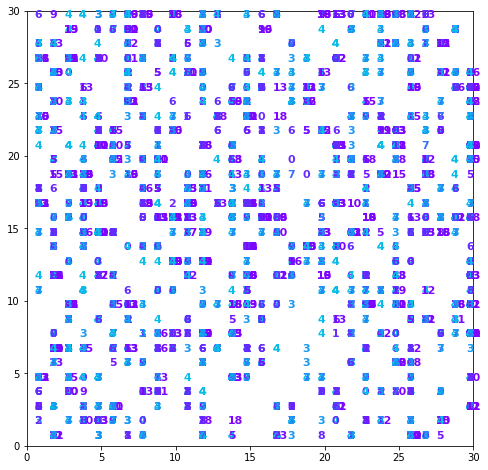

In [161]:
plt.figure(figsize=(8, 8))
wmap = {}
im = 0
for x, t in zip(fp_norm, labels):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt.text(w[0]+.5,  w[1]+.5,  str(dii[t]),color=plt.cm.rainbow(di[t] / 7856), fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.savefig('resulting_images/som_digts.png')
plt.show()

In [ ]:
#map 图是Color Quantization。inpy里的

In [162]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

In [ ]:
DATA_DIR='datasets/mnist'
transform=transforms.Compose( [transforms.ToTensor()])
train_data = datasets.MNIST(DATA_DIR, train=True, download=True, transform=transform)


In [ ]:
transforms.Compose( [transforms.ToTensor()])

In [171]:
import torch
batch_size=torch.randn(5,10)
weight=torch.ones(10,20*20)
a=weight.expand(batch_size.size()[0], -1, -1)
print(a.size())

torch.Size([5, 10, 400])


In [176]:
784**0.5

28.0

In [215]:
from torch import nn
pdist = nn.PairwiseDistance(p=2)
input1 = torch.randn( 3,5,1)
input2 = torch.randn( 3,5,10)
output = pdist(input1, input2)
#print(input1,input2)

In [217]:
output.size()

torch.Size([3, 10])

In [216]:
print(output)
output.min(dim=1)

tensor([[3.8581, 2.7510, 3.2380, 2.3477, 0.8924, 3.6555, 3.2934, 2.6933, 3.7055,
         2.8109],
        [3.8189, 4.6339, 3.2839, 2.6021, 3.4037, 3.1551, 2.2873, 3.5827, 3.4290,
         4.2342],
        [2.5698, 3.5105, 0.9314, 2.7071, 2.3713, 3.6499, 2.5632, 2.5961, 2.5001,
         2.5120]])


(tensor([0.8924, 2.2873, 0.9314]), tensor([4, 6, 2]))

In [214]:
output = pdist(input1.t(), input2.t())
print(output)
output.min()

tensor([5.7968, 5.5589, 4.6727, 5.7623, 4.1791, 4.0689, 5.5423, 3.9243, 5.2312,
        4.0850])


tensor(3.9243)

In [207]:
input2.min(dim=0)

(tensor([-0.6491, -0.3075, -1.3217, -2.1527, -0.2752, -1.1715, -1.5919, -2.3381,
         -1.5442, -0.5945]), tensor([3, 1, 0, 0, 2, 4, 2, 3, 4, 3]))

In [206]:
input2

tensor([[ 1.0152,  1.1073, -1.3217, -2.1527,  1.5293, -0.2529, -0.2319, -0.1961,
          0.4335,  0.2889],
        [-0.5268, -0.3075, -0.5943, -0.5505,  0.1937,  0.0991,  0.0499,  1.0780,
          0.8455,  0.9519],
        [ 1.5498,  0.2765,  0.5029,  0.3138, -0.2752,  0.4065, -1.5919, -0.1030,
          0.7087, -0.4202],
        [-0.6491,  0.0262, -1.1500,  0.0297,  3.9375,  0.9222,  0.4920, -2.3381,
         -1.0829, -0.5945],
        [ 1.2238, -0.2234,  0.3843,  1.9698,  1.1658, -1.1715,  1.9515, -0.2867,
         -1.5442, -0.5204]])

In [240]:
pdist = nn.PairwiseDistance(p=2)
input1 = torch.randn(1,2, 3)
input2 = torch.randn(1,2, 3)
output = pdist(input1, input2)

In [241]:
output.size()

torch.Size([1, 3])

In [242]:
print(input1.size())
print(input2.size())
print(output.size())

torch.Size([1, 2, 3])
torch.Size([1, 2, 3])
torch.Size([1, 3])


In [244]:
output.size()

torch.Size([2])

In [245]:
print(input1.size())
print(input2.size())
print(output.size())

torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2])


In [18]:
import torch
from torch import nn

In [43]:
a=[[4,0,0],[4,0,0],[4,0,0],[4,0,0]]
b=[[2,2,2],[2,2,2],[2,2,2],[2,2,2]]#直接用2 来阔 2,2,2    相减 在**2  +   **0.5
input2=torch.FloatTensor([[b,b,b],[b,b,b]])
input1=torch.FloatTensor([[a,a,a],[a,a,a]])
pdist = nn.PairwiseDistance(p=2)
print(input1.size())
print(input2.size())

torch.Size([2, 3, 4, 3])
torch.Size([2, 3, 4, 3])


print(torch.FloatTensor(b))
pdist(torch.FloatTensor(a),torch.FloatTensor(b))

In [44]:
print(torch.FloatTensor(a)) 
print(torch.FloatTensor(b)) 
pdist(torch.FloatTensor(a),torch.FloatTensor(b))

tensor([[4., 0., 0.],
        [4., 0., 0.],
        [4., 0., 0.],
        [4., 0., 0.]])
tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])


tensor([3.4641, 3.4641, 3.4641, 3.4641])

In [48]:
pdist = nn.PairwiseDistance(p=2,keepdim=True)
print(input1)
print(input2)
print(pdist(input1,input2).size())
pdist(input1,input2)

tensor([[[[4., 0., 0.],
          [4., 0., 0.],
          [4., 0., 0.],
          [4., 0., 0.]],

         [[4., 0., 0.],
          [4., 0., 0.],
          [4., 0., 0.],
          [4., 0., 0.]],

         [[4., 0., 0.],
          [4., 0., 0.],
          [4., 0., 0.],
          [4., 0., 0.]]],


        [[[4., 0., 0.],
          [4., 0., 0.],
          [4., 0., 0.],
          [4., 0., 0.]],

         [[4., 0., 0.],
          [4., 0., 0.],
          [4., 0., 0.],
          [4., 0., 0.]],

         [[4., 0., 0.],
          [4., 0., 0.],
          [4., 0., 0.],
          [4., 0., 0.]]]])
tensor([[[[2., 2., 2.],
          [2., 2., 2.],
          [2., 2., 2.],
          [2., 2., 2.]],

         [[2., 2., 2.],
          [2., 2., 2.],
          [2., 2., 2.],
          [2., 2., 2.]],

         [[2., 2., 2.],
          [2., 2., 2.],
          [2., 2., 2.],
          [2., 2., 2.]]],


        [[[2., 2., 2.],
          [2., 2., 2.],
          [2., 2., 2.],
          [2., 2., 2.]],

         [[2., 

tensor([[[[3.4641, 3.4641, 3.4641],
          [3.4641, 3.4641, 3.4641],
          [3.4641, 3.4641, 3.4641],
          [3.4641, 3.4641, 3.4641]]],


        [[[3.4641, 3.4641, 3.4641],
          [3.4641, 3.4641, 3.4641],
          [3.4641, 3.4641, 3.4641],
          [3.4641, 3.4641, 3.4641]]]])

In [34]:
12**0.5

3.4641016151377544

In [31]:
pdist(torch.FloatTensor([[2],[1]]),torch.FloatTensor([[4],[1]]))

tensor([2.0000e+00, 1.0000e-06])

In [276]:
torch.FloatTensor([[2],[1]])

tensor([[2.],
        [1.]])

In [270]:
input2=torch.FloatTensor(b)
input1=torch.FloatTensor(a)
pdist = nn.PairwiseDistance(p=2)

In [255]:
pdist(input1,input2)

tensor([1.4142, 1.4142])

In [259]:
torch.pairwise_distance(input2, input1, 2)

tensor([1.4142, 1.4142])

In [63]:
a=input1.mul_(input2).size()

RuntimeError: output with shape [2, 1, 3, 4, 3] doesn't match the broadcast shape [2, 2, 3, 4, 3]

In [62]:
a.unsqueeze_(1).permute(4,0,1,2,3)

RuntimeError: number of dims don't match in permute

In [61]:
a=torch.randn(5,4,1)
b=torch.randn(4,5)
print(f'a={a},b={b},a-b={(a-b).size()}')

a=tensor([[[-0.2698],
         [-1.1547],
         [-0.1845],
         [ 2.5239]],

        [[ 0.0592],
         [-0.6575],
         [ 0.9731],
         [-0.3818]],

        [[-1.3259],
         [-0.3649],
         [-1.5527],
         [ 0.5724]],

        [[ 0.8082],
         [-0.8155],
         [ 0.6779],
         [-1.2919]],

        [[-0.3912],
         [ 1.1577],
         [ 0.8518],
         [-1.3901]]]),b=tensor([[-1.4381,  0.1980, -0.0967,  0.2470, -0.8591],
        [ 1.6229,  1.3022,  0.2621, -0.6108, -1.3457],
        [-0.7730, -0.2339,  1.4740,  0.3887,  0.4493],
        [ 0.2742, -1.2291,  1.6683,  1.1290,  1.1621]]),a-b=torch.Size([5, 4, 5])


In [90]:
class_parameters = [
    dict(
        marker='o',
        markeredgecolor='#E24A33',
        markersize=11,
        markeredgewidth=2,
        markerfacecolor='None',
    ),
    dict(
        marker='s',
        markeredgecolor='#348ABD',
        markersize=14,
        markeredgewidth=2,
        markerfacecolor='None',
    ),
]

In [95]:
from itertools import product

In [97]:
product(range(5), range(5))

In [98]:
a = np.arange(4).reshape((2,2))

b=np.amax(a)
v=b-a

In [101]:
import argparse

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing
from neupy import algorithms, utils

from competitive.utils import iter_neighbours


--->msvcp140.dll


ModuleNotFoundError: No module named 'competitive'

In [105]:
def load_data():
    data, target = datasets.load_breast_cancer(return_X_y=True)

    scaler = preprocessing.MinMaxScaler()
    data = scaler.fit_transform(data)

In [103]:
GRID_HEIGHT = 20
GRID_WIDTH = 20

sofm = algorithms.SOFM(
    n_inputs=30,
    features_grid=(GRID_HEIGHT, GRID_WIDTH),

    learning_radius=4,
    reduce_radius_after=50,

    step=0.5,
    std=1,

    shuffle_data=True,
    verbose=True,
)


Main information

[ALGORITHM] SOFM

[OPTION] distance = ['euclid', 'neg_euclid_distance']
[OPTION] features_grid = [20, 20]
[OPTION] grid_type = ['rectangle', 'find_neighbours_on_rect_grid', 'find_step_scaler_on_rect_grid']
[OPTION] learning_radius = 4
[OPTION] n_inputs = 30
[OPTION] n_outputs = None
[OPTION] reduce_radius_after = 50
[OPTION] reduce_std_after = 100
[OPTION] reduce_step_after = 100
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] std = 1
[OPTION] step = 0.5
[OPTION] verbose = True
[OPTION] weight = Normal(mean=0, std=0.01)



TypeError: 'NoneType' object is not iterable